# Step 0: Preprocessing

## Imports and definitions

In [1]:
import math
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pm4py
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net.variants import pydotplus_vis
from pm4py.visualization.heuristics_net import visualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns

In [2]:
subfolder = "data" + os.sep
no_students = pd.read_csv(subfolder + "no_students.csv", header=None)[0].tolist()
select_courses = [5]
select_sections_per_course = {5: [1,2,3,4]}

## Load scrolling data

In [3]:
df_scroll = pd.read_csv(subfolder + "scroll.csv", sep=";", parse_dates=["timecreated", "value.utc"])
df_scroll

C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\IPython\core\interactiveshell.py:3397: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,userid,courseid,timecreated,value.utc,value.pageid,value.relativeTime,value.targetID,value.targetTag,value.targetClasses,value.scrollXDistance,value.scrollYDistance,value.scrollHeight,value.scrollWidth,value.containerHeight,value.containerWidth,value.behavior,value.targetWordCount
0,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.249999872,12.0,4323.445,paragraph-18,div,longpage-image-block longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
1,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.246000128,12.0,4326.965,paragraph-16,p,longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
2,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.239000064,12.0,4325.960,paragraph-1,ul,nav navbar-nav ml-auto longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
3,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.254000128,12.0,4328.960,paragraph-19,p,longpage-image-caption longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
4,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.257999872,12.0,4486.070,paragraph-28,p,longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212219,314,5,2021-03-10 15:20:05,2021-03-10 15:20:02.836000000,41.0,40078.795,paragraph-1,h2,dummy-heading longpage-paragraph,0.0,417.000000,448.0,-17.0,724.0,708.0,reading,1.0
212220,314,5,2021-03-10 15:20:18,2021-03-10 15:20:04.268999936,41.0,41511.340,longpage-paragraph-1,ul,longpage-paragraph,0.0,199.000000,448.0,-17.0,724.0,708.0,reading,8.0
212221,314,5,2021-03-10 15:20:18,2021-03-10 15:20:17.196999936,41.0,54442.260,longpage-paragraph-10,p,longpage-paragraph,0.0,200.000000,448.0,-17.0,724.0,708.0,scrolling,1.0
212222,314,5,2021-03-10 15:20:22,2021-03-10 15:20:17.199000064,41.0,54442.445,paragraph-1,h2,dummy-heading longpage-paragraph,0.0,200.000000,448.0,-17.0,724.0,708.0,reading,1.0


In [4]:
df_scroll.dtypes

userid                            int64
courseid                          int64
timecreated              datetime64[ns]
value.utc                datetime64[ns]
value.pageid                    float64
value.relativeTime              float64
value.targetID                   object
value.targetTag                  object
value.targetClasses              object
value.scrollXDistance           float64
value.scrollYDistance           float64
value.scrollHeight              float64
value.scrollWidth               float64
value.containerHeight           float64
value.containerWidth            float64
value.behavior                   object
value.targetWordCount           float64
dtype: object

## Remove unknown pages and old versions of scrolling info
## Select courses and students

In [6]:
user_acceptances = pd.read_csv(subfolder + "user_acceptances.csv", sep=";")

In [7]:
df_scroll = df_scroll[(~df_scroll["value.pageid"].isna()) & (~df_scroll["value.utc"].isna())]
df_scroll = df_scroll[df_scroll["courseid"].isin(select_courses)]
df_scroll = df_scroll[(~df_scroll["userid"].isin(no_students)) & (df_scroll["userid"].isin(user_acceptances[user_acceptances["Einwilligungserklärung zur Forschungsbeteiligung"] == "Akzeptiert"]["userid"]))]
df_scroll

,userid,courseid,timecreated,value.utc,value.pageid,value.relativeTime,value.targetID,value.targetTag,value.targetClasses,value.scrollXDistance,value.scrollYDistance,value.scrollHeight,value.scrollWidth,value.containerHeight,value.containerWidth,value.behavior,value.targetWordCount
0,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.249999872,12.0,4323.445,paragraph-18,div,longpage-image-block longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
1,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.246000128,12.0,4326.965,paragraph-16,p,longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
2,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.239000064,12.0,4325.960,paragraph-1,ul,nav navbar-nav ml-auto longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
3,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.254000128,12.0,4328.960,paragraph-19,p,longpage-image-caption longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
4,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.257999872,12.0,4486.070,paragraph-28,p,longpage-paragraph,0.0,2823.199951,53903.0,-17.0,54022.0,720.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212219,314,5,2021-03-10 15:20:05,2021-03-10 15:20:02.836000000,41.0,40078.795,paragraph-1,h2,dummy-heading longpage-paragraph,0.0,417.000000,448.0,-17.0,724.0,708.0,reading,1.0
212220,314,5,2021-03-10 15:20:18,2021-03-10 15:20:04.268999936,41.0,41511.340,longpage-paragraph-1,ul,longpage-paragraph,0.0,199.000000,448.0,-17.0,724.0,708.0,reading,8.0
212221,314,5,2021-03-10 15:20:18,2021-03-10 15:20:17.196999936,41.0,54442.260,longpage-paragraph-10,p,longpage-paragraph,0.0,200.000000,448.0,-17.0,724.0,708.0,scrolling,1.0
212222,314,5,2021-03-10 15:20:22,2021-03-10 15:20:17.199000064,41.0,54442.445,paragraph-1,h2,dummy-heading longpage-paragraph,0.0,200.000000,448.0,-17.0,724.0,708.0,reading,1.0


## Derive reading sessions from scrolling data

In [8]:
df_scroll = df_scroll.sort_values("value.utc")

In [9]:
lim = (1000*60*10) #10mins
lim

600000

In [10]:
diffprev = df_scroll.groupby(["userid", "value.pageid"], sort=False)[["value.utc","value.relativeTime"]].apply(func=lambda x: x.diff())

diffprev

,value.utc,value.relativeTime
2,NaT,NaN
1,0 days 00:00:00.007000064,1.005
0,0 days 00:00:00.003999744,-3.520
3,0 days 00:00:00.004000256,5.515
4,0 days 00:00:00.003999744,157.110
...,...,...
212218,0 days 00:00:01.431000064,1432.320
212220,0 days 00:00:00.001999872,0.225
212221,0 days 00:00:12.928000,12930.920
212222,0 days 00:00:00.002000128,0.185


In [11]:
diffnext = df_scroll.groupby(["userid", "value.pageid"], sort=False)[["value.utc","value.relativeTime"]].apply(func=lambda x: x.diff(-1))
diffnext

,value.utc,value.relativeTime
2,-1 days +23:59:59.992999936,-1.005
1,-1 days +23:59:59.996000256,3.520
0,-1 days +23:59:59.995999744,-5.515
3,-1 days +23:59:59.996000256,-157.110
4,-1 days +23:59:59.995999744,1.465
...,...,...
212218,-1 days +23:59:59.998000128,-0.225
212220,-1 days +23:59:47.072000,-12930.920
212221,-1 days +23:59:59.997999872,-0.185
212222,-1 days +23:59:56.168999936,-3832.250


### Define session borders

In [12]:
df_scroll[["diffprev_utc","diffprev_relativeTime"]] = diffprev
df_scroll[["diffnext_utc","diffnext_relativeTime"]] = diffnext
df_scroll["sessionstart"] = (df_scroll["diffprev_relativeTime"].isna()) | (df_scroll["diffprev_relativeTime"] < -1*lim) | (df_scroll["diffprev_utc"] > "10 minutes")
df_scroll["sessionend"] = (df_scroll["diffnext_relativeTime"].isna()) | (df_scroll["diffnext_relativeTime"] > lim) | (df_scroll["diffnext_utc"] < "-10 minutes")
df_scroll["sessionbreakstart"] = (df_scroll["diffnext_relativeTime"] < -1*0.5*lim) & (~df_scroll["sessionend"])
df_scroll["sessionbreakend"] = (df_scroll["diffprev_relativeTime"] > 0.5*lim) & (~df_scroll["sessionstart"]) 

#remove single scroll events
df_scroll = df_scroll[~(df_scroll["sessionstart"] & df_scroll["sessionend"])]

#separate events where start and breakstart are identical
dd = df_scroll[(df_scroll["sessionstart"] & df_scroll["sessionbreakstart"])]
df_scroll.loc[(df_scroll["sessionstart"]) & (df_scroll["sessionbreakstart"]), "sessionbreakstart"] = False
dd["sessionstart"] = False
dd["value.utc"] = dd["value.utc"] + pd.offsets.Second(1)
df_scroll = pd.concat([df_scroll, dd])

#separate events where end and breakend are identical
dd = df_scroll[(df_scroll["sessionend"] & df_scroll["sessionbreakend"])]
df_scroll.loc[(df_scroll["sessionend"]) & (df_scroll["sessionbreakend"]), "sessionbreakend"] = False
dd["sessionend"] = False
dd["value.utc"] = dd["value.utc"] - pd.offsets.Second(1)
df_scroll = pd.concat([df_scroll, dd])

#separate events where breakstart and breakend are identical
dd = df_scroll[(df_scroll["sessionbreakstart"] & df_scroll["sessionbreakend"])]
df_scroll.loc[(df_scroll["sessionbreakstart"]) & (df_scroll["sessionbreakend"]), "sessionbreakend"] = False
dd["sessionbreakstart"] = False
dd["value.utc"] = dd["value.utc"] - pd.offsets.Second(1)
df_scroll = pd.concat([df_scroll, dd])

df_scroll = df_scroll.sort_values("value.utc")
del diffnext, diffprev, dd, lim

C:\Users\menze\AppData\Local\Temp\ipykernel_22628\4063380644.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd["sessionstart"] = False
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\4063380644.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd["value.utc"] = dd["value.utc"] + pd.offsets.Second(1)
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\4063380644.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


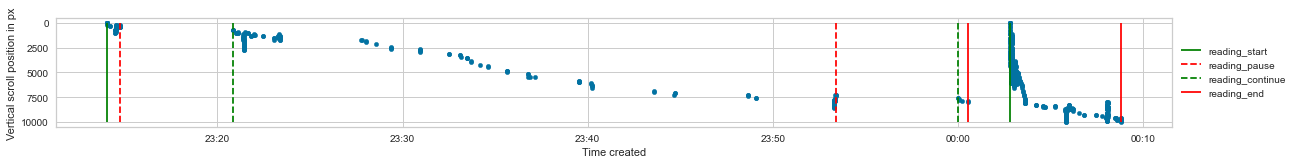

In [13]:
mpl.rcParams['figure.figsize'] = [20, 2]

d = df_scroll[(df_scroll.userid == 1116) & (df_scroll.courseid == 5) & (df_scroll["value.pageid"] == 12) & (df_scroll["value.utc"] > "10.09.2020 15:00") & (df_scroll["value.utc"] < "10.10.2020 05:00")]
fig = d.plot.scatter("value.utc", "value.scrollYDistance", xlabel="Time created", ylabel="Vertical scroll position in px")
fig.invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M")) 
plt.gca().vlines(d.loc[d["sessionstart"]==1, "value.utc"], 0, 10000, colors="green", label="reading_start") 
plt.gca().vlines(d.loc[d["sessionbreakstart"]==1, "value.utc"], 0, 10000, colors="red", linestyles="dashed", label="reading_pause")
plt.gca().vlines(d.loc[d["sessionbreakend"]==1, "value.utc"], 0, 10000, colors="green", linestyles="dashed", label="reading_continue")
plt.gca().vlines(d.loc[d["sessionend"]==1, "value.utc"], 0, 10000, colors="red", label="reading_end")
fig.legend(loc="center left", bbox_to_anchor=(1, 0.5))
fig
plt.rc('font', size=15)
plt.rc("axes", titlesize=15)
plt.rc("legend", fontsize=12)
plt.savefig("reading_session.png", dpi=300, bbox_inches='tight')
del d

### Filter scroll logs between start and end

In [14]:
df_session = df_scroll[(df_scroll["sessionstart"] == True) | (df_scroll["sessionend"] == True) | (df_scroll["sessionbreakstart"] == True) | (df_scroll["sessionbreakend"] == True)]
df_session

,userid,courseid,timecreated,value.utc,value.pageid,value.relativeTime,value.targetID,value.targetTag,value.targetClasses,value.scrollXDistance,...,value.behavior,value.targetWordCount,diffprev_utc,diffprev_relativeTime,diffnext_utc,diffnext_relativeTime,sessionstart,sessionend,sessionbreakstart,sessionbreakend
2,695,5,2020-10-07 00:15:02,2020-10-07 00:15:01.239000064,12.0,4325.960,paragraph-1,ul,nav navbar-nav ml-auto longpage-paragraph,0.0,...,NaN,NaN,NaT,NaN,-1 days +23:59:59.992999936,-1.005,True,False,False,False
248,695,5,2020-10-07 00:18:16,2020-10-07 00:18:15.268999936,12.0,3438.235,paragraph-12,p,longpage-paragraph,0.0,...,NaN,NaN,0 days 00:00:00.004999936,-2.935,-16 days +05:46:36.797999872,-1032.815,False,True,False,False
250,1667,5,2020-10-07 10:33:26,2020-10-07 10:33:25.350000128,12.0,4107.000,paragraph-0,ul,navbar-nav d-none d-md-flex longpage-paragraph,0.0,...,NaN,NaN,NaT,NaN,-1 days +23:59:59.985000192,0.000,True,False,False,False
505,1667,5,2020-10-07 10:34:50,2020-10-07 10:34:49.566000128,12.0,88396.000,longpage-features,ul,nav nav-tabs,0.0,...,NaN,NaN,0 days 00:00:00.034000128,43.000,-1 days +21:41:05.432000,-8334397.000,False,True,False,False
510,106,5,2020-10-07 13:04:10,2020-10-07 13:04:09.564000000,12.0,1552.000,paragraph-0,ul,navbar-nav d-none d-md-flex longpage-paragraph,0.0,...,NaN,NaN,NaT,NaN,-1 days +23:59:59.996999936,0.000,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212111,1637,5,2021-03-07 17:07:32,2021-03-07 17:07:31.639000064,45.0,1327.480,longpage-paragraph-4,p,longpage-paragraph,0.0,...,scrolling,30.0,0 days 00:00:00.000999936,0.015,NaT,NaN,False,True,False,False
212114,1391,5,2021-03-07 18:56:29,2021-03-07 18:56:28.854000128,12.0,1463.105,longpage-paragraph-0,p,longpage-paragraph,0.0,...,scrolling,14.0,0 days 03:02:09.637000192,-7450767.185,-1 days +23:59:59.978000128,1.885,True,False,False,False
212201,1391,5,2021-03-07 19:00:31,2021-03-07 19:00:26.644999936,12.0,239269.630,longpage-paragraph-231,p,longpage-paragraph,0.0,...,scrolling,146.0,0 days 00:00:01.209999872,1210.825,NaT,NaN,False,True,False,False
212202,314,5,2021-03-10 15:19:24,2021-03-10 15:19:23.884999936,41.0,1124.590,longpage-paragraph-0,ul,longpage-paragraph,0.0,...,scrolling,26.0,NaT,NaN,-1 days +23:59:59.996999936,-0.185,True,False,False,False


In [15]:
df_session["state"] = np.select([df_session["sessionstart"], df_session["sessionend"], df_session["sessionbreakstart"], df_session["sessionbreakend"]], ["sessionstart", "sessionend", "sessionbreakstart", "sessionbreakend"])
df_session["state"]

C:\Users\menze\AppData\Local\Temp\ipykernel_22628\2664659350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session["state"] = np.select([df_session["sessionstart"], df_session["sessionend"], df_session["sessionbreakstart"], df_session["sessionbreakend"]], ["sessionstart", "sessionend", "sessionbreakstart", "sessionbreakend"])


2         sessionstart
248         sessionend
250       sessionstart
505         sessionend
510       sessionstart
              ...     
212111      sessionend
212114    sessionstart
212201      sessionend
212202    sessionstart
212223      sessionend
Name: state, Length: 3240, dtype: object

In [16]:
df_session["sessionstart_or_breakend"] = df_session["sessionstart"] + df_session["sessionbreakend"] 
df_session["sessionid"] = df_session.groupby(["userid", "value.pageid"])["sessionstart_or_breakend"].cumsum()

C:\Users\menze\AppData\Local\Temp\ipykernel_22628\1752215291.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session["sessionstart_or_breakend"] = df_session["sessionstart"] + df_session["sessionbreakend"]
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\1752215291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_session["sessionid"] = df_session.groupby(["userid", "value.pageid"])["sessionstart_or_breakend"].cumsum()


In [17]:
df_session = df_session[["userid", "value.pageid", "sessionid", "state", "value.utc", "sessionstart", "sessionbreakstart", "sessionbreakend", "sessionend"]]

In [18]:
df_session = df_session.pivot(index=["userid", "value.pageid", "sessionid"], columns="state", values="value.utc")[["sessionstart", "sessionbreakstart", "sessionbreakend", "sessionend"]].reset_index()
df_session

state,userid,value.pageid,sessionid,sessionstart,sessionbreakstart,sessionbreakend,sessionend
0,72,12.0,1,2021-02-03 22:49:07.252000000,NaT,NaT,2021-02-03 22:49:30.247000064
1,106,12.0,1,2020-10-07 13:04:09.564000000,NaT,NaT,2020-10-07 13:21:41.523000064
2,106,12.0,2,2020-10-09 11:02:09.311000064,NaT,NaT,2020-10-09 11:04:05.537999872
3,106,12.0,3,2020-10-20 03:58:01.399000064,NaT,NaT,2020-10-20 03:58:01.436000000
4,147,41.0,1,2020-12-08 09:34:57.268999936,NaT,NaT,2020-12-08 09:35:29.924000000
...,...,...,...,...,...,...,...
1616,1875,15.0,1,2021-02-14 18:13:47.004999936,2021-02-14 18:15:42.451000064,NaT,NaT
1617,1875,15.0,2,NaT,NaT,2021-02-14 18:24:28.088,2021-02-14 18:24:28.628000000
1618,1875,41.0,1,2020-12-24 09:44:05.335000064,NaT,NaT,2020-12-24 09:44:06.807000064
1619,1879,12.0,1,2021-01-06 20:35:03.251000064,NaT,NaT,2021-01-06 20:35:40.641999872


### Filter pure breaks

In [19]:
df_session = df_session[~((~df_session["sessionbreakstart"].isna()) & (~df_session["sessionbreakend"].isna()))]
df_session

state,userid,value.pageid,sessionid,sessionstart,sessionbreakstart,sessionbreakend,sessionend
0,72,12.0,1,2021-02-03 22:49:07.252000000,NaT,NaT,2021-02-03 22:49:30.247000064
1,106,12.0,1,2020-10-07 13:04:09.564000000,NaT,NaT,2020-10-07 13:21:41.523000064
2,106,12.0,2,2020-10-09 11:02:09.311000064,NaT,NaT,2020-10-09 11:04:05.537999872
3,106,12.0,3,2020-10-20 03:58:01.399000064,NaT,NaT,2020-10-20 03:58:01.436000000
4,147,41.0,1,2020-12-08 09:34:57.268999936,NaT,NaT,2020-12-08 09:35:29.924000000
...,...,...,...,...,...,...,...
1616,1875,15.0,1,2021-02-14 18:13:47.004999936,2021-02-14 18:15:42.451000064,NaT,NaT
1617,1875,15.0,2,NaT,NaT,2021-02-14 18:24:28.088,2021-02-14 18:24:28.628000000
1618,1875,41.0,1,2020-12-24 09:44:05.335000064,NaT,NaT,2020-12-24 09:44:06.807000064
1619,1879,12.0,1,2021-01-06 20:35:03.251000064,NaT,NaT,2021-01-06 20:35:40.641999872


## Load and preprocess quiz attempts

In [20]:
df_attempts = pd.read_csv(subfolder + "m_quiz_attempts.csv", sep=";")
df_attempts = df_attempts[(~df_attempts["userid"].isin(no_students)) & (df_attempts["userid"].isin(user_acceptances[user_acceptances["Einwilligungserklärung zur Forschungsbeteiligung"] == "Akzeptiert"]["userid"]))] 
df_attempts

,id,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,timefinish,timemodified,timemodifiedoffline,timecheckstate,sumgrades
0,53,7,106,3,60,"1,0",0,0,finished,1570354517,1570354523,1570354523,0,NaN,0.0
1,54,7,106,4,61,"1,0",0,0,finished,1570354544,1570354556,1570354556,0,NaN,2.0
2,59,11,106,1,66,"1,0",0,0,finished,1570354913,1570355397,1570355397,0,NaN,2.0
3,55,8,106,1,62,"1,0",0,0,finished,1570354578,1570354603,1570354603,0,NaN,2.0
4,11660,118,1512,1,12069,"1,0",0,0,inprogress,1609072621,0,1609072644,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5996,13548,14,1067,2,14242,"1,0",0,0,finished,1614804441,1614804858,1614804858,0,NaN,6.0
5997,13474,150,1611,2,14164,"1,0,2,0,3,0",2,0,finished,1614755026,1614755138,1614755138,0,NaN,0.0
5998,13553,49,1067,2,14247,"1,0",0,0,finished,1614805223,1614805311,1614805311,0,NaN,6.0
5999,13552,19,1067,2,14246,"1,0",0,0,finished,1614805194,1614805209,1614805209,0,NaN,2.0


In [21]:
df_attempts["timestart"] = pd.to_datetime(df_attempts["timestart"], unit="s")
df_attempts["timefinish"] = pd.to_datetime(df_attempts["timefinish"], unit="s")
df_attempts["timemodified"] = pd.to_datetime(df_attempts["timemodified"], unit="s")

In [22]:
df_quiz = pd.read_csv(subfolder + "m_quiz.csv", sep=";")
df_quiz = df_quiz[(df_quiz.course.isin(select_courses))]
df_quiz

,id,course,name,intro,introformat,timeopen,timeclose,timelimit,overduehandling,graceperiod,...,password,subnet,browsersecurity,delay1,delay2,showuserpicture,showblocks,completionattemptsexhausted,completionpass,allowofflineattempts
0,154,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
1,77,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
2,134,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
3,85,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
4,125,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,128,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
63,129,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
64,131,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0
65,130,5,<removed>,<removed>,1,0,0,0,autosubmit,0,...,NaN,NaN,-,0,0,0,0,0,0,0


## Merge quiz and attempts and define quiz success or fail

In [23]:
df_attempts = df_attempts.merge(df_quiz, left_on="quiz", right_on="id", suffixes=["_attempt", "_quiz"])
df_attempts["result"] = "fail"
df_attempts.loc[(df_attempts["sumgrades_attempt"] / df_attempts["sumgrades_quiz"]) > 0.8, "result"] = "success"

## Assignments and Grades

In [24]:
df_assignments = pd.read_csv(subfolder + "m_assign.csv", sep=";")
df_assignments = df_assignments[df_assignments["course"].isin(select_courses)]

In [25]:
df_assignment_grades = pd.read_csv(subfolder + "m_assign_grades.csv", sep=";")
df_assignment_grades = df_assignment_grades[~df_assignment_grades["userid"].isin(no_students)]
df_assignment_grades = df_assignment_grades[df_assignment_grades["grade"] >= 0]
df_assignment_grades = df_assignment_grades.merge(df_assignments, left_on="assignment", right_on="id", suffixes=["_grades", "_assign"])
df_assignment_grades["result"] = df_assignment_grades["grade_grades"] / df_assignment_grades["grade_assign"]
df_assignment_grades["duedate"] = pd.to_datetime(df_assignment_grades["duedate"], unit="s")
df_assignment_grades["timecreated"] = pd.to_datetime(df_assignment_grades["timecreated"], unit="s")
df_assignment_grades["allowsubmissionsfromdate"] = pd.to_datetime(df_assignment_grades["allowsubmissionsfromdate"], unit="s")
df_assignment_grades

,id_grades,assignment,userid,timecreated,timemodified_grades,grader,grade_grades,attemptnumber,id_assign,course,...,teamsubmissiongroupingid,blindmarking,revealidentities,attemptreopenmethod,maxattempts,markingworkflow,markingallocation,sendstudentnotifications,preventsubmissionnotingroup,result
0,2106,42,215,2020-10-14 09:37:20,1604127383,1404,14.0,0,42,5,...,0,0,0,none,-1,0,0,1,0,0.875000
1,2137,42,519,2020-10-14 09:38:44,1604126036,1404,11.0,0,42,5,...,0,0,0,none,-1,0,0,1,0,0.687500
2,2216,42,1488,2020-10-14 09:41:43,1604126670,1404,12.0,0,42,5,...,0,0,0,none,-1,0,0,1,0,0.750000
3,2532,42,1482,2020-10-25 11:00:04,1604126318,1404,12.0,0,42,5,...,0,0,0,none,-1,0,0,1,0,0.750000
4,2620,42,1356,2020-10-25 19:16:02,1604126177,1404,14.0,0,42,5,...,0,0,0,none,-1,0,0,1,0,0.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,3322,70,1584,2021-01-31 12:15:02,1612264946,1400,10.0,0,70,5,...,0,0,0,none,-1,0,0,1,0,0.666667
1134,3231,70,1116,2021-01-11 11:30:02,1612265620,1400,15.0,0,70,5,...,0,0,0,none,-1,0,0,1,0,1.000000
1135,3315,70,1507,2021-01-30 18:00:02,1612265731,1400,15.0,0,70,5,...,0,0,0,none,-1,0,0,1,0,1.000000
1136,3323,70,294,2021-01-31 17:00:02,1612265778,1400,14.0,0,70,5,...,0,0,0,none,-1,0,0,1,0,0.933333


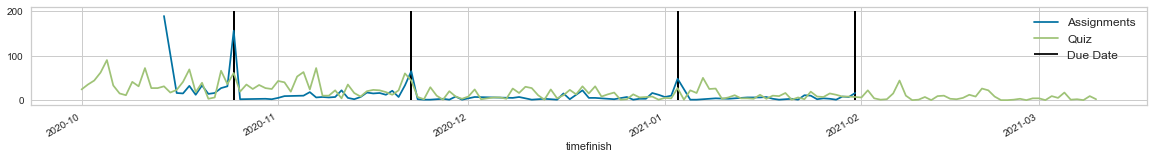

In [26]:
ax = df_assignment_grades.groupby(df_assignment_grades["timecreated"].dt.date)["timecreated"].count().plot(label="Assignments")

df_attempts[(df_attempts["state"] == "finished")].resample("D", on="timefinish")["timefinish"].count().plot(ax=ax, label="Quiz")

ax.vlines(df_assignment_grades["duedate"].dt.date, 0, 200, colors="black", label="Due Date")
ax.legend()

## Modules and sections

In [27]:
# Module IDS:
# 1 assign
# 15 page
# 16 quiz / assessment

In [28]:
df_course_modules = pd.read_csv(subfolder + "m_course_modules.csv", sep=";")
df_course_modules = pd.merge(df_course_modules, pd.read_csv(subfolder + "m_course_sections.csv", sep=";"), left_on="section", right_on="id", suffixes=["_modules", "_sections"])
df = pd.DataFrame()
for key, val in select_sections_per_course.items():
    df = df.append(df_course_modules[(df_course_modules["course_modules"] == key) & (df_course_modules["section_sections"].isin(val))])
df_course_modules = df.copy()
del df
df_course_modules

,id_modules,course_modules,module,instance,section_modules,idnumber,added,score,indent,visible_modules,...,id_sections,course_sections,section_sections,name,summary,summaryformat,sequence,visible_sections,availability_sections,timemodified
10,248,5,15,12,38,NaN,1567679805,0,0,1,...,38,5,1,<removed>,<removed>,1,"248,497,249,251,252,253,254,255,256,257,506,44...",1,NaN,1593412771
11,249,5,1,39,38,NaN,1569316579,0,1,1,...,38,5,1,<removed>,<removed>,1,"248,497,249,251,252,253,254,255,256,257,506,44...",1,NaN,1593412771
12,251,5,1,41,38,NaN,1569317573,0,1,1,...,38,5,1,<removed>,<removed>,1,"248,497,249,251,252,253,254,255,256,257,506,44...",1,NaN,1593412771
13,252,5,1,42,38,NaN,1569317838,0,1,1,...,38,5,1,<removed>,<removed>,1,"248,497,249,251,252,253,254,255,256,257,506,44...",1,NaN,1593412771
14,255,5,1,45,38,NaN,1569318239,0,1,1,...,38,5,1,<removed>,<removed>,1,"248,497,249,251,252,253,254,255,256,257,506,44...",1,NaN,1593412771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,345,5,16,137,41,NaN,1574685462,0,1,1,...,41,5,4,<removed>,<removed>,1,"343,499,337,338,339,340,341,342,460,344,345,34...",1,NaN,1593412780
135,346,5,16,138,41,NaN,1574685978,0,1,1,...,41,5,4,<removed>,<removed>,1,"343,499,337,338,339,340,341,342,460,344,345,34...",1,NaN,1593412780
136,347,5,16,139,41,NaN,1574759045,0,1,1,...,41,5,4,<removed>,<removed>,1,"343,499,337,338,339,340,341,342,460,344,345,34...",1,NaN,1593412780
137,349,5,16,141,41,NaN,1574760748,0,1,1,...,41,5,4,<removed>,<removed>,1,"343,499,337,338,339,340,341,342,460,344,345,34...",1,NaN,1593412780


## Merge section to reading

In [29]:
df_session = pd.merge(df_session, df_course_modules.loc[df_course_modules["module"] == 15, ["instance", "name", "section_sections"]], left_on="value.pageid", right_on="instance", suffixes=["_session", "_sections"]).drop("instance", axis=1).rename({"section_sections":"section"}, axis=1)
df_session

,userid,value.pageid,sessionid,sessionstart,sessionbreakstart,sessionbreakend,sessionend,name,section
0,72,12.0,1,2021-02-03 22:49:07.252000000,NaT,NaT,2021-02-03 22:49:30.247000064,<removed>,1
1,106,12.0,1,2020-10-07 13:04:09.564000000,NaT,NaT,2020-10-07 13:21:41.523000064,<removed>,1
2,106,12.0,2,2020-10-09 11:02:09.311000064,NaT,NaT,2020-10-09 11:04:05.537999872,<removed>,1
3,106,12.0,3,2020-10-20 03:58:01.399000064,NaT,NaT,2020-10-20 03:58:01.436000000,<removed>,1
4,171,12.0,1,2020-11-21 13:24:21.238000128,NaT,NaT,2020-11-21 13:26:07.524999936,<removed>,1
...,...,...,...,...,...,...,...,...,...
1192,1635,15.0,2,2021-01-22 18:51:08.468000000,NaT,NaT,2021-01-22 18:51:20.288999936,<removed>,4
1193,1729,15.0,1,2020-12-16 17:19:27.529999872,NaT,NaT,2020-12-16 17:19:33.681999872,<removed>,4
1194,1835,15.0,1,2020-12-17 21:54:10.828000000,NaT,NaT,2020-12-17 21:56:32.612000000,<removed>,4
1195,1875,15.0,1,2021-02-14 18:13:47.004999936,2021-02-14 18:15:42.451000064,NaT,NaT,<removed>,4


## Merge section to assessment

In [30]:
df_attempts = pd.merge(df_attempts, df_course_modules.loc[df_course_modules["module"] == 16, ["instance", "name", "section_sections"]], left_on="quiz", right_on="instance", suffixes=["_attempts", "_sections"]).drop("instance", axis=1).rename({"section_sections":"section"}, axis=1)
df_attempts

,id_attempt,quiz,userid,attempt,uniqueid,layout,currentpage,preview,state,timestart,...,delay1,delay2,showuserpicture,showblocks,completionattemptsexhausted,completionpass,allowofflineattempts,result,name_sections,section
0,11660,118,1512,1,12069,"1,0",0,0,inprogress,2020-12-27 12:37:01,...,0,0,0,0,0,0,0,fail,<removed>,3
1,12522,118,1320,1,13020,"1,0",0,0,finished,2021-02-02 09:25:57,...,0,0,0,0,0,0,0,fail,<removed>,3
2,12520,118,759,1,13018,"1,0",0,0,finished,2021-02-02 06:22:17,...,0,0,0,0,0,0,0,fail,<removed>,3
3,11719,118,841,1,12140,"1,0",0,0,inprogress,2020-12-30 16:30:21,...,0,0,0,0,0,0,0,fail,<removed>,3
4,11746,118,1523,1,12167,"1,0",0,0,inprogress,2021-01-02 11:16:14,...,0,0,0,0,0,0,0,fail,<removed>,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,10851,115,841,1,11201,"1,0",0,0,finished,2020-11-22 16:14:18,...,0,0,0,0,0,0,0,success,<removed>,2
3661,11229,115,1480,1,11598,"1,0",0,0,finished,2020-12-10 09:21:10,...,0,0,0,0,0,0,0,success,<removed>,2
3662,11595,115,1512,1,11990,"1,0",0,0,finished,2020-12-22 10:34:38,...,0,0,0,0,0,0,0,success,<removed>,2
3663,12937,115,1283,2,13513,"1,0",0,0,finished,2021-02-18 06:47:11,...,0,0,0,0,0,0,0,success,<removed>,2


## Merge section to assignment

In [31]:
df_assignment_grades = pd.merge(df_assignment_grades, df_course_modules.loc[df_course_modules["module"] == 1, ["instance", "name", "section_sections"]], left_on="assignment", right_on="instance", suffixes=["_grades", "_sections"]).drop("instance", axis=1).rename({"section_sections":"section"}, axis=1)
df_assignment_grades

,id_grades,assignment,userid,timecreated,timemodified_grades,grader,grade_grades,attemptnumber,id_assign,course,...,revealidentities,attemptreopenmethod,maxattempts,markingworkflow,markingallocation,sendstudentnotifications,preventsubmissionnotingroup,result,name_sections,section
0,2106,42,215,2020-10-14 09:37:20,1604127383,1404,14.0,0,42,5,...,0,none,-1,0,0,1,0,0.875000,<removed>,1
1,2137,42,519,2020-10-14 09:38:44,1604126036,1404,11.0,0,42,5,...,0,none,-1,0,0,1,0,0.687500,<removed>,1
2,2216,42,1488,2020-10-14 09:41:43,1604126670,1404,12.0,0,42,5,...,0,none,-1,0,0,1,0,0.750000,<removed>,1
3,2532,42,1482,2020-10-25 11:00:04,1604126318,1404,12.0,0,42,5,...,0,none,-1,0,0,1,0,0.750000,<removed>,1
4,2620,42,1356,2020-10-25 19:16:02,1604126177,1404,14.0,0,42,5,...,0,none,-1,0,0,1,0,0.875000,<removed>,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,3322,70,1584,2021-01-31 12:15:02,1612264946,1400,10.0,0,70,5,...,0,none,-1,0,0,1,0,0.666667,<removed>,4
1134,3231,70,1116,2021-01-11 11:30:02,1612265620,1400,15.0,0,70,5,...,0,none,-1,0,0,1,0,1.000000,<removed>,4
1135,3315,70,1507,2021-01-30 18:00:02,1612265731,1400,15.0,0,70,5,...,0,none,-1,0,0,1,0,1.000000,<removed>,4
1136,3323,70,294,2021-01-31 17:00:02,1612265778,1400,14.0,0,70,5,...,0,none,-1,0,0,1,0,0.933333,<removed>,4


## Action types coding

### Reading

In [32]:
# Codes: 
# Reading - reading_start, reading_short, reading_medium, reading_long, reading_pause, reading_continue, reading_end

In [33]:
_, bins = pd.qcut(df_session["sessionbreakstart"] - df_session["sessionstart"], 3, retbins=True)
bins

TimedeltaIndex([   '0 days 00:00:00.004000', '0 days 00:00:38.285000021',
                '0 days 00:07:14.100333311', '0 days 00:44:52.206000128'],
               dtype='timedelta64[ns]', freq=None)

In [34]:
_, bins = pd.qcut(df_session["sessionend"] - df_session["sessionstart"], 3, retbins=True)
bins

TimedeltaIndex(['0 days 00:00:00.000999936', '0 days 00:00:12.446666581',
                '0 days 00:03:12.390333354', '0 days 00:59:36.903000064'],
               dtype='timedelta64[ns]', freq=None)

In [35]:
_, bins = pd.qcut(df_session["sessionend"] - df_session["sessionbreakend"], 3, retbins=True)
bins

TimedeltaIndex(['0 days 00:00:00.003000064', '0 days 00:00:33.118333354',
                '0 days 00:05:53.488333311',    '0 days 00:47:56.332000'],
               dtype='timedelta64[ns]', freq=None)

In [36]:
df_session.loc[(df_session["sessionbreakstart"] - df_session["sessionstart"]) > "5 minutes", "action"] = "reading_long"
df_session.loc[(df_session["sessionbreakstart"] - df_session["sessionstart"]) < "5 minutes", "action"] = "reading_medium"
df_session.loc[(df_session["sessionbreakstart"] - df_session["sessionstart"]) < "1 minute", "action"] = "reading_short"
df_session.loc[(~df_session["sessionbreakstart"].isna()) & (~df_session["sessionstart"].isna()), "timestamp"] = df_session.loc[(~df_session["sessionbreakstart"].isna()) & (~df_session["sessionstart"].isna()), "sessionstart"] 

df_session.loc[(df_session["sessionend"] - df_session["sessionstart"]) > "5 minutes", "action"] = "reading_long"
df_session.loc[(df_session["sessionend"] - df_session["sessionstart"]) < "5 minutes", "action"] = "reading_medium"
df_session.loc[(df_session["sessionend"] - df_session["sessionstart"]) < "1 minute", "action"] = "reading_short"
df_session.loc[(~df_session["sessionend"].isna()) & (~df_session["sessionstart"].isna()), "timestamp"] = df_session.loc[(~df_session["sessionend"].isna()) & (~df_session["sessionstart"].isna()), "sessionstart"] 


df_session.loc[(df_session["sessionend"] - df_session["sessionbreakend"]) > "5 minutes", "action"] = "reading_long"
df_session.loc[(df_session["sessionend"] - df_session["sessionbreakend"]) < "5 minutes", "action"] = "reading_medium"
df_session.loc[(df_session["sessionend"] - df_session["sessionbreakend"]) < "1 minute", "action"] = "reading_short"
df_session.loc[(~df_session["sessionend"].isna()) & (~df_session["sessionbreakend"].isna()), "timestamp"] = df_session.loc[(~df_session["sessionend"].isna()) & (~df_session["sessionbreakend"].isna()), "sessionbreakend"] 

df_session.loc[df_session["action"].isin(["reading_short", "reading_medium", "reading_long"]), "timestamp"] += pd.DateOffset(milliseconds=1)

d1 = df_session[~df_session["sessionstart"].isna()]
d1["action"] = "reading_start"
d1["timestamp"] = d1["sessionstart"]

d2 = df_session[~df_session["sessionbreakstart"].isna()]
d2["action"] = "reading_pause"
d2["timestamp"] = d2["sessionbreakstart"]

d3 = df_session[~df_session["sessionbreakend"].isna()]
d3["action"] = "reading_continue"
d3["timestamp"] = d3["sessionbreakend"]

d4 = df_session[~df_session["sessionend"].isna()]
d4["action"] = "reading_end"
d4["timestamp"] = d4["sessionend"]
df_session = pd.concat([df_session, d1, d2, d3, d4])

df_session = df_session.sort_values("timestamp")
del d1, d2, d3, d4

C:\Users\menze\AppData\Local\Temp\ipykernel_22628\613141067.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["action"] = "reading_start"
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\613141067.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d1["timestamp"] = d1["sessionstart"]
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\613141067.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

### Quiz

In [37]:
# Codes:
# Quiz - quiz_start, quiz_repeat_same, quiz_repeat_other, quiz_success, quiz_fail

In [38]:
df_attempts["timestamp"] = df_attempts["timestart"]

df_attempts.loc[df_attempts["attempt"] == 1, "action"] = "quiz_start"
df_attempts.loc[df_attempts["attempt"] > 1, "action"] = "quiz_repeat_other"

d = df_attempts[df_attempts["state"] == "finished"]
d.loc[d["result"] == "success", "action"] = "quiz_success"
d.loc[d["result"] == "fail", "action"] = "quiz_fail"
d["timestamp"] = d["timefinish"]

df_attempts = pd.concat([df_attempts, d])
df_attempts = df_attempts.sort_values("timestamp")
del d

C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
C:\Users\menze\AppData\Local\Temp\ipykernel_22628\2519260043.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["timestamp"] = d["timefinish"]


## Merge quizzes and attempts

In [39]:
df_action = pd.concat([df_session[["userid", "value.pageid","timestamp", "action"]], df_attempts[["userid", "quiz","timestamp", "action", "sumgrades_attempt", "sumgrades_quiz"]]])
df_action["timestamp"] = df_action["timestamp"].astype("datetime64")
df_action = df_action.sort_values("timestamp").reset_index(drop=True)
df_action

,userid,value.pageid,timestamp,action,quiz,sumgrades_attempt,sumgrades_quiz
0,1498,NaN,2020-10-01 15:12:32,quiz_start,77.0,0.0,2.0
1,1498,NaN,2020-10-01 15:13:35,quiz_fail,77.0,0.0,2.0
2,1498,NaN,2020-10-01 15:14:28,quiz_start,78.0,NaN,4.0
3,1251,NaN,2020-10-01 16:00:26,quiz_start,77.0,2.0,2.0
4,1251,NaN,2020-10-01 16:03:09,quiz_success,77.0,2.0,2.0
...,...,...,...,...,...,...,...
10074,886,NaN,2021-03-09 20:42:17,quiz_success,94.0,12.0,12.0
10075,886,NaN,2021-03-10 08:11:56,quiz_start,95.0,0.0,6.0
10076,886,NaN,2021-03-10 08:12:04,quiz_fail,95.0,0.0,6.0
10077,886,NaN,2021-03-10 09:20:22,quiz_start,96.0,0.0,10.0


## Define session (break) length

In [40]:
df_action["sessionid"] = (df_action.groupby(["userid"])["timestamp"].apply(lambda x: (x.diff() > "45 minutes").cumsum()))
df_action

,userid,value.pageid,timestamp,action,quiz,sumgrades_attempt,sumgrades_quiz,sessionid
0,1498,NaN,2020-10-01 15:12:32,quiz_start,77.0,0.0,2.0,0
1,1498,NaN,2020-10-01 15:13:35,quiz_fail,77.0,0.0,2.0,0
2,1498,NaN,2020-10-01 15:14:28,quiz_start,78.0,NaN,4.0,0
3,1251,NaN,2020-10-01 16:00:26,quiz_start,77.0,2.0,2.0,0
4,1251,NaN,2020-10-01 16:03:09,quiz_success,77.0,2.0,2.0,0
...,...,...,...,...,...,...,...,...
10074,886,NaN,2021-03-09 20:42:17,quiz_success,94.0,12.0,12.0,14
10075,886,NaN,2021-03-10 08:11:56,quiz_start,95.0,0.0,6.0,15
10076,886,NaN,2021-03-10 08:12:04,quiz_fail,95.0,0.0,6.0,15
10077,886,NaN,2021-03-10 09:20:22,quiz_start,96.0,0.0,10.0,16


## Define quiz repeat

In [41]:
df_action["action"].value_counts()

quiz_start           2785
quiz_success         1473
quiz_fail            1350
reading_start         987
reading_end           987
quiz_repeat_other     880
reading_short         576
reading_long          355
reading_medium        266
reading_pause         210
reading_continue      210
Name: action, dtype: int64

In [42]:
df_action.loc[(df_action["action"] == "quiz_repeat_other") & (df_action.groupby(["userid", "sessionid", "quiz"])["timestamp"].rank() > 1), "action"] = "quiz_repeat_same"

## Action as names and integers

In [43]:
codes, actions = df_action["action"].factorize(sort=True)
codes, actions

(array([3, 0, 3, ..., 0, 3, 0], dtype=int64),
 Index(['quiz_fail', 'quiz_repeat_other', 'quiz_repeat_same', 'quiz_start',
        'quiz_success', 'reading_continue', 'reading_end', 'reading_long',
        'reading_medium', 'reading_pause', 'reading_short', 'reading_start'],
       dtype='object'))

In [44]:
l = actions.tolist()
df_action["action_name"] = df_action["action"]
df_action["action"] = df_action["action"].apply(lambda x: l.index(x))
del l
df_action["action"]

0        3
1        0
2        3
3        3
4        4
        ..
10074    4
10075    3
10076    0
10077    3
10078    0
Name: action, Length: 10079, dtype: int64

## Descriptive statistics

### Number of user sessions

In [45]:
len(df_action.groupby(["userid", "sessionid"]))

1359

### Number of log entries for reading and quiz

In [46]:
df_action.shape

(10079, 9)

### Max length of user sessions

In [47]:
df_action.groupby(["userid", "sessionid"]).apply(lambda x: len(x)).max()

84

### Users reading

In [48]:
df_action[df_action["action_name"].str.startswith("reading")]["userid"].nunique()

103

# Step 1: Modeling

## Process mining

In [49]:
X = df_action.copy()
X["caseid"] = X["userid"].astype(str) + "_" + X["sessionid"].astype(str)
X = X[["timestamp", "action_name", "caseid", "userid", "sessionid"]]
X

,timestamp,action_name,caseid,userid,sessionid
0,2020-10-01 15:12:32,quiz_start,1498_0,1498,0
1,2020-10-01 15:13:35,quiz_fail,1498_0,1498,0
2,2020-10-01 15:14:28,quiz_start,1498_0,1498,0
3,2020-10-01 16:00:26,quiz_start,1251_0,1251,0
4,2020-10-01 16:03:09,quiz_success,1251_0,1251,0
...,...,...,...,...,...
10074,2021-03-09 20:42:17,quiz_success,886_14,886,14
10075,2021-03-10 08:11:56,quiz_start,886_15,886,15
10076,2021-03-10 08:12:04,quiz_fail,886_15,886,15
10077,2021-03-10 09:20:22,quiz_start,886_16,886,16


## Feature generation

In [50]:
pd.qcut(X.groupby("caseid")["caseid"].count(), 3)

caseid
1022_0      (3.0, 7.0]
1023_0      (3.0, 7.0]
1023_1    (0.999, 3.0]
1067_0      (3.0, 7.0]
1067_1    (0.999, 3.0]
              ...     
996_7      (7.0, 84.0]
996_8      (7.0, 84.0]
996_9       (3.0, 7.0]
997_0       (3.0, 7.0]
997_1     (0.999, 3.0]
Name: caseid, Length: 1359, dtype: category
Categories (3, interval[float64, right]): [(0.999, 3.0] < (3.0, 7.0] < (7.0, 84.0]]

In [51]:
X["begin_reading"] = X.groupby("caseid").transform("first")["action_name"].str.startswith("reading").astype(int)
X["end_reading"] = X.groupby("caseid").transform("last")["action_name"].str.startswith("reading").astype(int)
X["seqlen_low"] = (X.groupby("caseid").transform("count")["action_name"] <= 3).astype(int)
X["seqlen_high"] = (X.groupby("caseid").transform("count")["action_name"] > 7).astype(int)
X["seqlen_mid"] = ((X.groupby("caseid").transform("count")["action_name"] > 3) & ~(X["seqlen_high"])).astype(int)
X["mid_reading"] = X.groupby("caseid")["action_name"].transform(lambda x: x.value_counts().index[0]).str.startswith("reading").astype(int)

C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\yellowbrick\cluster\elbow.py:330: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\yellowbrick\cluster\elbow.py:330: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (18). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\yellowbrick\cluster\elbow.py:330: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (19). Possibly due to duplicate points in X.
  self.estimator.fit(X, **kwargs)
C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\yellowbrick\cluster\elbow.py:330: ConvergenceWarning: Number of distinct clusters (16) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  self.estimator.fit(X

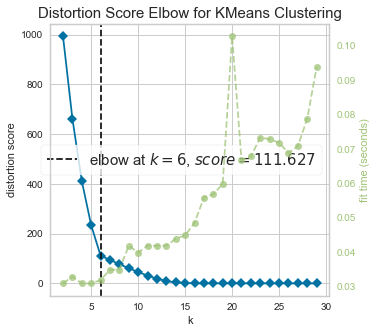

array([5, 0, 2, ..., 5, 5, 1])

In [52]:
plt.figure(figsize=(5,5))
kmeans = KMeans(random_state=1)
visualizer = KElbowVisualizer(kmeans, k=(2,30), metric="distortion")
visualizer.fit(X.groupby("caseid").first()[["begin_reading", "end_reading", "seqlen_low", "seqlen_mid", "seqlen_high", "mid_reading"]])
visualizer.show()
n_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
kmeans.fit(X.groupby("caseid").first()[["begin_reading", "end_reading", "seqlen_low", "seqlen_mid", "seqlen_high", "mid_reading"]])
kmeans.labels_

0.8854536381744011

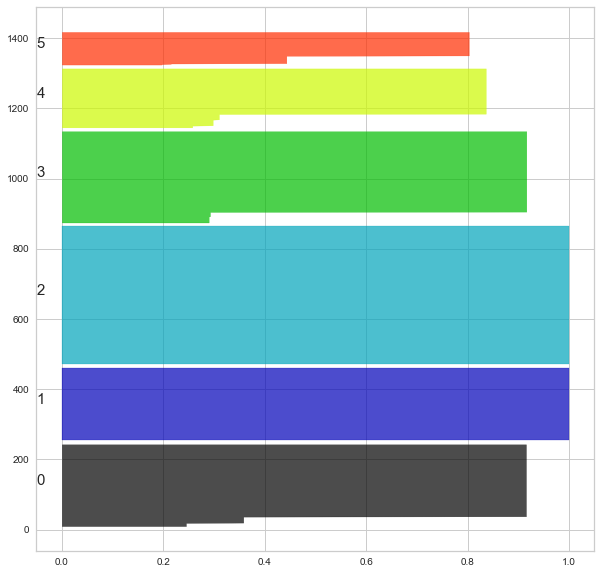

In [53]:
silhouette_avg = silhouette_score(X.groupby("caseid").first()[["begin_reading", "end_reading", "seqlen_low", "seqlen_mid", "seqlen_high", "mid_reading"]], kmeans.labels_)
sample_silhouette_values = silhouette_samples(X.groupby("caseid").first()[["begin_reading", "end_reading", "seqlen_low", "seqlen_mid", "seqlen_high", "mid_reading"]], kmeans.labels_)
y_lower = 10
fig = plt.figure(figsize=(10, 10))
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = mpl.cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
del y_lower, y_upper
silhouette_avg

### Assign clusters to data

In [54]:
i = 0
def cluster_to_groups(g):
    global i
    i += 1
    return kmeans.labels_[i-1]+1

X["cluster"] = X.groupby("caseid")["caseid"].transform(cluster_to_groups)
del i

## Plot subprocesses

C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\pm4py\utils.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[constants.CASE_CONCEPT_NAME] = df[case_id]
C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\pm4py\utils.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[xes_constants.DEFAULT_NAME_KEY] = df[activity_key]
C:\Users\menze\Anaconda3\envs\analysis\lib\site-packages\pm4py\utils.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


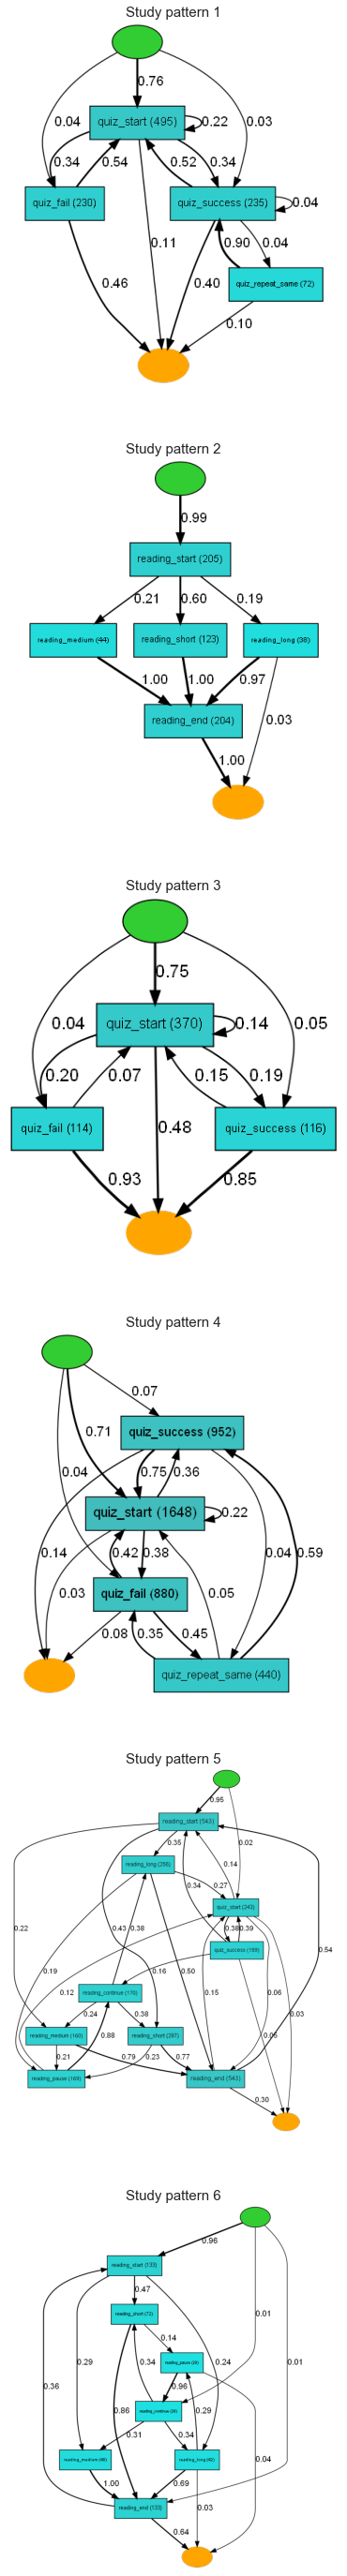

In [55]:
fig = plt.figure(figsize=(50,50))
plt.subplots_adjust(hspace=0.2)

for cluster in range(n_clusters):
    x = X[X["cluster"] == cluster+1]
    lg = pm4py.format_dataframe(x, case_id='caseid', activity_key='action_name', timestamp_key='timestamp')

    net = heuristics_miner.apply_heu(lg, parameters={
        heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.9,
        }, variant=pm4py.algo.discovery.heuristics.variants.classic)

    sumstart = sum(net.start_activities[0].values())
    sumend = sum(net.end_activities[0].values())
    sumnodes = sum(map(lambda x: x[1].node_occ, net.nodes.items()))
    
    for x in net.nodes.copy().items():
        if x[1].node_occ / sumnodes < 0.05:
            net.nodes.pop(x[0])

    graph = pydotplus_vis.get_graph(net)

    for edge in graph.get_edges().copy():
        src = edge.get_source()
        dst = edge.get_destination()

        graph.get_edge(src, dst)[0].set_fontname("Helvetica")

        if src == "start_0":
            val = net.start_activities[0][dst] / sumstart
        elif dst == "end_0" or src in net.dependency_matrix and dst in net.dependency_matrix[src]:
            val = int(edge.get_label()) / (sum([net.nodes[src].output_connections[y][0].repr_value for y in [x for x in net.nodes[src].output_connections]]) + (net.end_activities[0][src] if src in net.end_activities[0] else 0))#net.dependency_matrix[src][dst]

        if val < 0.01:
            graph.del_edge(src, dst)
        else:
            edge = graph.get_edge(src, dst)[0]
            edge.set_label("{:.2f}".format(val))
            edge.set_penwidth(1.0 + math.log(1 + val)*2)
    
    edges = graph.get_edges()
    for node in graph.get_nodes().copy():
        name = node.obj_dict["name"]
        nxt = next((x for x in edges if x.obj_dict["points"][0] != name and x.obj_dict["points"][1] == name), None)
        node = graph.get_node(node.obj_dict["name"])[0]
        node.set_fontname("Helvetica")
        if name not in ["start_0", "end_0"]:
            factor = math.log(net.activities_occurrences[name])*2
            node.set_fontsize(factor)
    
    file_name = "graph_"+str(cluster+1)+".png"
    graph.write(file_name, format="png")
    img = mpl.image.imread(file_name)
    
    plt.subplot(n_clusters, 1, cluster+1)
    plt.title("Study pattern " + str(cluster+1), loc="center")
    plt.grid(False)
    plt.axis("off")
    plt.imshow(img)

    graph.write_dot("graph_"+str(cluster+1)+".txt")
    
del sumstart, sumend, sumnodes

## Define study pattern from cluster

In [56]:
for cluster in range(n_clusters):
    X.loc[X["cluster"] == cluster+1, "study_pattern"] = "Sub-process " + str(cluster+1)

## Descriptive Statistics

### Users per subprocess

In [57]:
X.groupby(["study_pattern"])["userid"].nunique()

study_pattern
Sub-process 1    82
Sub-process 2    71
Sub-process 3    95
Sub-process 4    71
Sub-process 5    34
Sub-process 6    48
Name: userid, dtype: int64

### Number of sessions per subprocess

In [58]:
X.groupby(["caseid"]).first()["study_pattern"].value_counts(sort=False).sort_index()

Sub-process 1    234
Sub-process 2    207
Sub-process 3    394
Sub-process 4    261
Sub-process 5    169
Sub-process 6     94
Name: study_pattern, dtype: int64

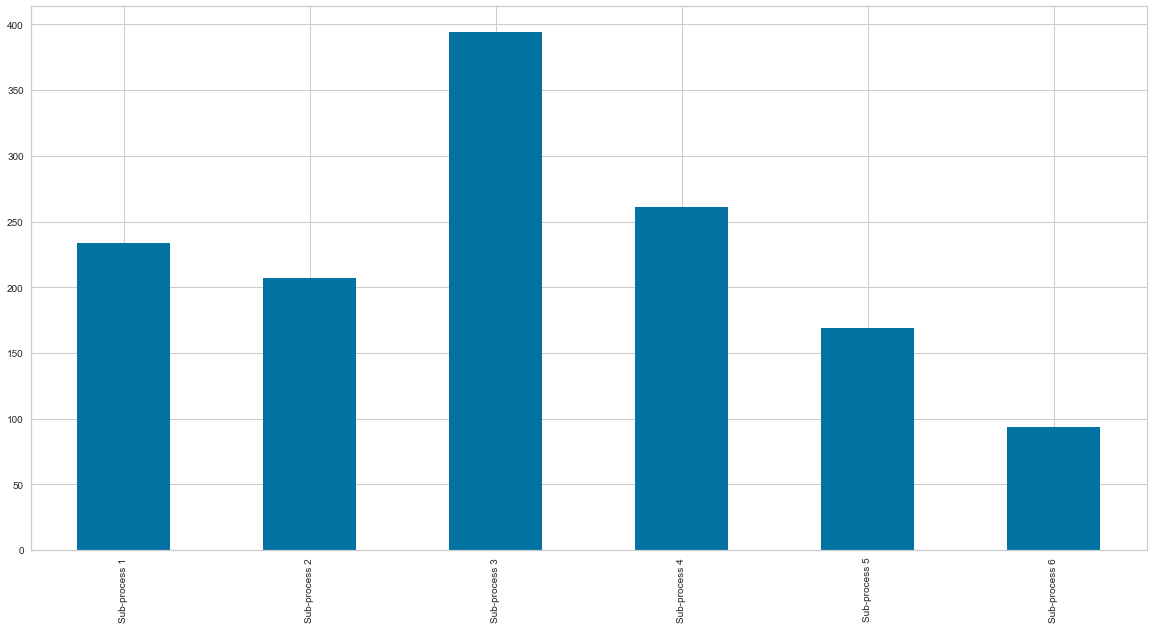

In [59]:
X.groupby(["caseid"]).first()["study_pattern"].value_counts(sort=False).sort_index().plot(kind="bar", figsize=(20,10))
plt.savefig("subprocess_hist.png")

### Mean sessions per user

In [60]:
X.groupby(["study_pattern", "userid"])["action_name"].count().groupby(["study_pattern"]).agg(["mean", "std"])

,mean,std
study_pattern,,
Sub-process 1,14.475610,12.492196
Sub-process 2,8.676056,9.558504
Sub-process 3,7.221053,7.811855
Sub-process 4,60.661972,43.158493
Sub-process 5,80.764706,99.043626
Sub-process 6,11.187500,12.614845


In [61]:
X.groupby(["study_pattern", "userid"])["action_name"].count().agg(["mean", "std"])

mean    25.134663
std     43.288645
Name: action_name, dtype: float64

In [62]:
X["userid"].nunique()

142

# Step 2: Cluster students by study pattern over study periods

In [63]:
df_patterns = X.copy()

## Define study period as times between assignment due dates (plus tail)

In [64]:
periods = df_assignment_grades["duedate"].sort_values().unique()
periods = np.append(periods, [np.datetime64('2021-02-28T22:59:00.000000000'), np.datetime64('2021-03-31T22:59:00.000000000')])
periods

array(['2020-10-25T22:59:00.000000000', '2020-11-22T22:59:00.000000000',
       '2021-01-03T22:59:00.000000000', '2021-01-31T22:59:00.000000000',
       '2021-02-28T22:59:00.000000000', '2021-03-31T22:59:00.000000000'],
      dtype='datetime64[ns]')

## Define period names

In [65]:
period_names = ["P1", "P2", "P3", "P4", "P5", "P6"]

## Name study periods

In [66]:
for i, duedate in enumerate(reversed(periods)):
    df_patterns.loc[df_patterns["timestamp"] < duedate, "period"] = period_names[-(i+1)]

## Descriptive statistics

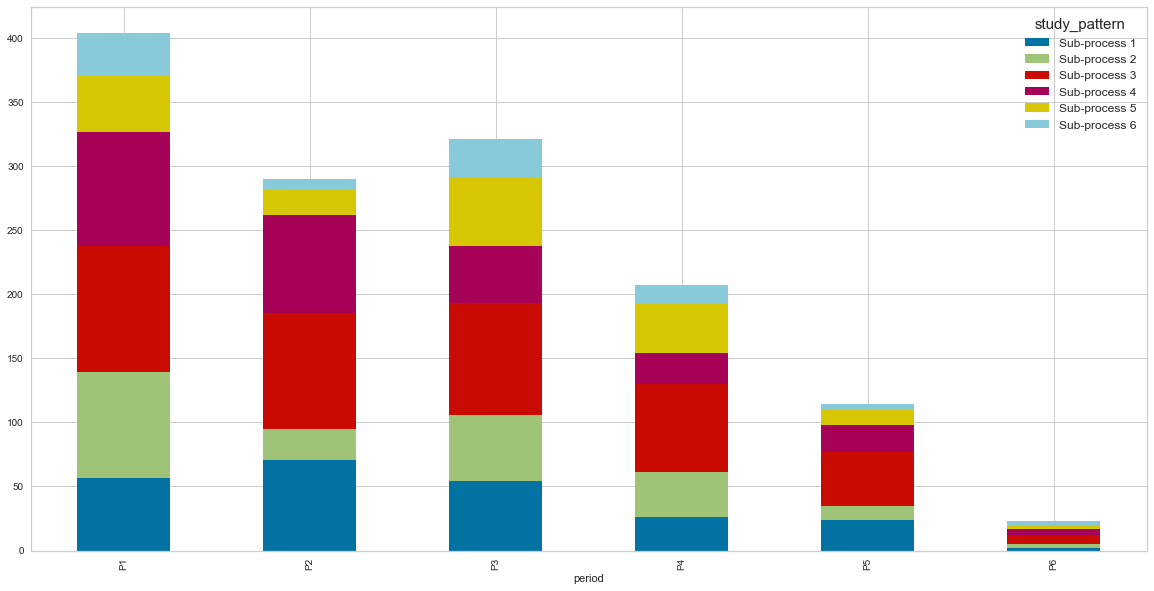

In [67]:
df_patterns.groupby(["caseid"]).first()[["period","study_pattern"]].value_counts().unstack().plot(kind="bar", stacked=True, figsize=(20,10))
plt.savefig("period_hist.png")

## Manually combine subprocesses

In [68]:
df_patterns = df_patterns.replace({
    "Sub-process 1": "Mainly quiz", 
    "Sub-process 2": "Mainly reading",
    "Sub-process 3": "Mainly quiz",
    "Sub-process 4": "Mainly quiz",
    "Sub-process 5": "Reading and quiz",
    "Sub-process 6": "Mainly reading"
    })
df_patterns

,timestamp,action_name,caseid,userid,sessionid,begin_reading,end_reading,seqlen_low,seqlen_high,seqlen_mid,mid_reading,cluster,study_pattern,period
0,2020-10-01 15:12:32,quiz_start,1498_0,1498,0,0,0,1,0,0,0,3,Mainly quiz,P1
1,2020-10-01 15:13:35,quiz_fail,1498_0,1498,0,0,0,1,0,0,0,3,Mainly quiz,P1
2,2020-10-01 15:14:28,quiz_start,1498_0,1498,0,0,0,1,0,0,0,3,Mainly quiz,P1
3,2020-10-01 16:00:26,quiz_start,1251_0,1251,0,0,0,0,1,0,0,4,Mainly quiz,P1
4,2020-10-01 16:03:09,quiz_success,1251_0,1251,0,0,0,0,1,0,0,4,Mainly quiz,P1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10074,2021-03-09 20:42:17,quiz_success,886_14,886,14,0,0,0,1,0,0,4,Mainly quiz,P6
10075,2021-03-10 08:11:56,quiz_start,886_15,886,15,0,0,1,0,0,0,3,Mainly quiz,P6
10076,2021-03-10 08:12:04,quiz_fail,886_15,886,15,0,0,1,0,0,0,3,Mainly quiz,P6
10077,2021-03-10 09:20:22,quiz_start,886_16,886,16,0,0,1,0,0,0,3,Mainly quiz,P6


## Distribution of subprocesses per student and period

In [69]:
d = df_patterns.copy()
d["study_pattern"] = d["study_pattern"].astype("category")
labels = d["study_pattern"].cat.categories.tolist()
df_patterns = d.pivot_table(index="userid", values="study_pattern", columns="period", aggfunc=lambda x: labels[x.value_counts(normalize=True, sort=False).argmax()]).replace(np.nan, "(No reading/quiz)").astype(str).reset_index()
del d, labels
df_patterns

period,userid,P1,P2,P3,P4,P5,P6
0,68,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz)
1,72,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz)
2,94,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz)
3,106,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz)
4,123,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz)
...,...,...,...,...,...,...,...
137,1835,(No reading/quiz),Mainly quiz,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz)
138,1845,(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz),Mainly quiz,(No reading/quiz)
139,1875,(No reading/quiz),(No reading/quiz),Mainly quiz,Mainly quiz,Mainly quiz,(No reading/quiz)
140,1879,(No reading/quiz),(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz),(No reading/quiz)


## Clustering

### One-Hot Encoding

In [70]:
df_patterns_dummies = pd.get_dummies(df_patterns.drop("userid", axis=1))
df_patterns_dummies

,P1_(No reading/quiz),P1_Mainly quiz,P1_Mainly reading,P1_Reading and quiz,P2_(No reading/quiz),P2_Mainly quiz,P2_Mainly reading,P2_Reading and quiz,P3_(No reading/quiz),P3_Mainly quiz,...,P4_Mainly quiz,P4_Mainly reading,P4_Reading and quiz,P5_(No reading/quiz),P5_Mainly quiz,P5_Reading and quiz,P6_(No reading/quiz),P6_Mainly quiz,P6_Mainly reading,P6_Reading and quiz
0,0,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
2,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,1,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,1,0,0,0
138,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
139,1,0,0,0,1,0,0,0,0,1,...,1,0,0,0,1,0,1,0,0,0
140,1,0,0,0,1,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,0


### KMeans

array([5, 1, 4, 5, 4, 4, 4, 5, 1, 4, 4, 6, 3, 2, 2, 6, 6, 1, 1, 2, 6, 1,
       3, 3, 6, 0, 6, 1, 1, 3, 1, 6, 1, 4, 1, 0, 2, 6, 2, 5, 1, 4, 5, 1,
       3, 4, 3, 2, 2, 2, 3, 3, 4, 0, 2, 4, 1, 6, 6, 3, 2, 6, 2, 4, 2, 4,
       4, 4, 4, 5, 3, 3, 4, 1, 3, 3, 3, 6, 6, 6, 1, 3, 2, 3, 4, 3, 4, 3,
       0, 6, 5, 3, 4, 0, 5, 0, 3, 1, 4, 3, 2, 0, 0, 4, 3, 2, 0, 6, 3, 5,
       3, 4, 4, 4, 2, 6, 5, 4, 4, 6, 2, 3, 3, 6, 4, 3, 6, 6, 6, 2, 4, 4,
       2, 2, 4, 2, 2, 3, 1, 1, 1, 1])

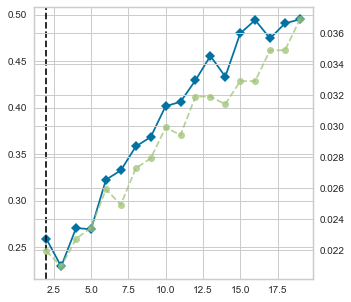

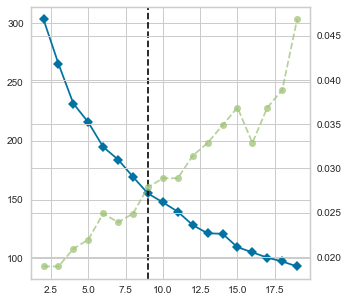

In [71]:
kmeans = KMeans(random_state=1)
plt.figure(figsize=(5,5))
visualizer = KElbowVisualizer(kmeans, k=(2,20), metric="silhouette")
visualizer.fit(df_patterns_dummies)
plt.figure(figsize=(5,5))
visualizer = KElbowVisualizer(kmeans, k=(2,20), metric="distortion")
visualizer.fit(df_patterns_dummies)
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=1)
labels = kmeans.fit_predict(df_patterns_dummies)
labels

### Get distortion score

In [72]:
visualizer.k_scores_[n_clusters-1]

169.3105651257354

0.3327020062128268

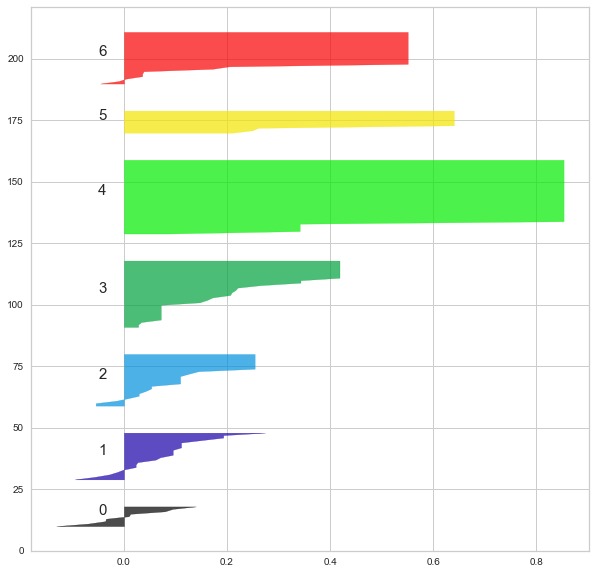

In [73]:
silhouette_avg = silhouette_score(df_patterns_dummies, labels)
sample_silhouette_values = silhouette_samples(df_patterns_dummies, labels)
y_lower = 10
fig = plt.figure(figsize=(10, 10))
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = mpl.cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
silhouette_avg

### Assign clusters to data

In [74]:
df_patterns["cluster"] = labels
df_patterns

period,userid,P1,P2,P3,P4,P5,P6,cluster
0,68,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),5
1,72,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz),1
2,94,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),4
3,106,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),5
4,123,Mainly quiz,(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),(No reading/quiz),4
...,...,...,...,...,...,...,...,...
137,1835,(No reading/quiz),Mainly quiz,Mainly quiz,Mainly quiz,(No reading/quiz),(No reading/quiz),3
138,1845,(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz),Mainly quiz,(No reading/quiz),1
139,1875,(No reading/quiz),(No reading/quiz),Mainly quiz,Mainly quiz,Mainly quiz,(No reading/quiz),1
140,1879,(No reading/quiz),(No reading/quiz),(No reading/quiz),Mainly quiz,(No reading/quiz),(No reading/quiz),1


C:\Users\menze\AppData\Local\Temp\ipykernel_22628\550143646.py:21: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(hspace=0.2)


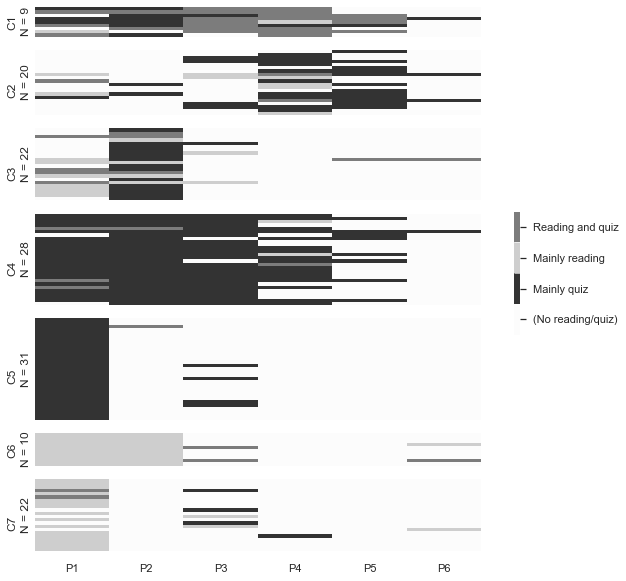

In [75]:
values = list(np.sort(pd.unique(df_patterns.drop(["cluster", "userid"], axis=1).values.ravel())))

value_to_int = {j:i for i,j in enumerate(values)}
n = len(value_to_int)
cmap = sns.color_palette("Paired", n) 


cmap = [[0.99, 0.99, 0.99],'#333333','#cecece',   '#7c7c7c']

sns.set(rc={'figure.figsize':(8,10)})


fig, ax = plt.subplots(n_clusters,1, sharex=True, 
                    constrained_layout=True,
                 gridspec_kw={'height_ratios':df_patterns.groupby("cluster")["cluster"].count()})

for i,x in df_patterns.groupby("cluster"):
    sns.heatmap(ax=ax[i], data=x.drop(["cluster", "userid"], axis=1).replace(value_to_int), \
    cmap=cmap, cbar_kws = dict(use_gridspec=False,location="right", shrink=4.5, anchor=(0,4), drawedges=True), yticklabels=False)
    
    plt.subplots_adjust(hspace=0.2)
    # modify colorbar:
    colorbar = ax[i].collections[0].colorbar 
    if i == 0:
        r = colorbar.vmax - colorbar.vmin 
        colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
        colorbar.ax.set_yticklabels(list(value_to_int.keys()),rotation=0)
    else:
        colorbar.remove()

    ax[i].set_title("C" + str(i+1), rotation='vertical',x=-0.05,y=len(x)/100)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("N = " + str(len(x)) + "")

fig.savefig("periods_clustering.png", bbox_inches="tight", dpi=300)

## Descriptive statistics

### No. of sessions per cluster

In [76]:
i = 1
d = pd.DataFrame()
for userids in df_patterns.groupby("cluster")["userid"].unique():
    cnt = pd.DataFrame(X[X["userid"].isin(userids)].replace({
    "Sub-process 1": "Mainly quiz", 
    "Sub-process 2": "Mainly reading",
    "Sub-process 3": "Mainly quiz",
    "Sub-process 4": "Mainly quiz",
    "Sub-process 5": "Reading and quiz",
    "Sub-process 6": "Mainly reading"
    }).groupby(["caseid"]).first()["study_pattern"].value_counts())
    cnt["cluster"] = i
    d = pd.concat([d, cnt])
    i += 1
d = d.rename_axis("index").sort_values(by=["cluster", "index"] )
print(d)
d.groupby(d.index).sum(), d.groupby("cluster").sum(), d.groupby(d.index).sum().sum()

                  study_pattern  cluster
index                                   
Mainly quiz                 106        1
Mainly reading              125        1
Reading and quiz            108        1
Mainly quiz                 123        2
Mainly reading               25        2
Reading and quiz              8        2
Mainly quiz                  53        3
Mainly reading               47        3
Reading and quiz             20        3
Mainly quiz                 441        4
Mainly reading               51        4
Reading and quiz             24        4
Mainly quiz                  76        5
Mainly reading               12        5
Reading and quiz              5        5
Mainly quiz                  79        6
Mainly reading               13        6
Mainly quiz                  11        7
Mainly reading               28        7
Reading and quiz              4        7


(                  study_pattern  cluster
 index                                   
 Mainly quiz                 889       28
 Mainly reading              301       28
 Reading and quiz            169       22,
          study_pattern
 cluster               
 1                  339
 2                  156
 3                  120
 4                  516
 5                   93
 6                   92
 7                   43,
 study_pattern    1359
 cluster            78
 dtype: int64)

### Sessions per learner per cluster

In [77]:
i = 1
for userids in df_patterns.groupby("cluster")["userid"].unique():
    print("Cluster " + str(i))
    i += 1
    print(X[X["userid"].isin(userids)].groupby(["userid", "caseid"])["userid"].count().agg(["mean", "std"]))

Cluster 1
mean    8.722714
std     9.045241
Name: userid, dtype: float64
Cluster 2
mean    6.641026
std     7.853455
Name: userid, dtype: float64
Cluster 3
mean    7.433333
std     8.026985
Name: userid, dtype: float64
Cluster 4
mean    7.213178
std     8.907785
Name: userid, dtype: float64
Cluster 5
mean    6.666667
std     6.827587
Name: userid, dtype: float64
Cluster 6
mean    6.793478
std     9.829914
Name: userid, dtype: float64
Cluster 7
mean    5.279070
std     5.820021
Name: userid, dtype: float64
